In [15]:
%reset -f

import pandas as pd
import numpy
import time
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import pandas as pd
import numpy
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import time
import pandas as pd
import os.path
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2 
from sklearn.metrics import mean_squared_log_error
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Image, display
import tensorflow
os.environ['PATH'] += ';C:\\Program Files\\Graphviz\\bin'
import graphviz
from IPython.display import Image
from keras.utils.vis_utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor



from sklearn.model_selection import KFold

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

# !pip install talos
import talos


def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [16]:
environment_variables = dir()

In [17]:
# Input parameters
TRAINING_FILES = ["../data/original/training_dataset.csv"
, "..\data\preprocessed\difference_preprocessed_training_dataset.csv"
, "..\data\preprocessed\ole_RemoveOutliers_and_preprocessing_pipe_training_dataset.csv"]
EVALUATION_FILES = ["../data/original/evaluation_dataset.csv"
, "..\data\preprocessed\difference_preprocessed_evaluation_dataset.csv"
, "..\data\preprocessed\ole_RemoveOutliers_and_preprocessing_pipe_evaluation_dataset.csv"]

FILE_N = 2
INPUT_TRAINING_FILE = TRAINING_FILES[FILE_N] 
INPUT_EVALUATION_FILE = EVALUATION_FILES[FILE_N]


# Output parameters
METHOD_NAME = "keras_tensorflow_sequential"
TIMESTAMP = time.strftime("%d_%m_%Y-%H_%M_%S")
OUTPUT_MODEL_FOLDER = f"../data/models/keras_models"
OUTPUT_MODEL = f"../data/models/{METHOD_NAME}_keras_model_{TIMESTAMP}.pkl"
OUTPUT_RESULTS = f"../data/results/{METHOD_NAME}_model_{TIMESTAMP}.txt"
OUTPUT_MODEL_ARCHITECTURE_RESULTS = f"../img/{METHOD_NAME}_model_{TIMESTAMP}.png"


# Hyper parameter optimization parameters
HYPER_PARAMETER_OPTIMIZATION_SCORING = "accuracy"
HYPER_PARAMETER_OPTIMIZATION_CV = 5

# Cross validation parameters
CROSS_VALIDATION_CV = 5

# Cost parameters
PUNISHMENT_FOR_FALSE_BANKRUPT_PREDICTION = 100

# Other constants
LABELS = ["Operational", "Bankrupt"]
RANDOM_SEED = 42

# Hyper parameter alternatives
HYPER_PARAMETER_K_FEATURES = list(range(30, 90, 10))
HYPER_PARAMETER_SCORE_FUNC = [chi2, f_classif]
HYPER_PARAMETER_HIDDEN_LAYER_SIZES = [(100,)]
HYPER_PARAMETER_ALPHA = list(10.0 ** -numpy.arange(1, 7))
HYPER_PARAMETER_CLASIFIER_OPTIMIZERS = ['rmsprop','adam','adagrad']
HYPER_PARAMETER_EPOCHS = [10,20,40,60]
HYPER_PARAMETER_DROPUT = [0,0.1,0.2,0.3]
HYPER_PARAMETER_LAYERS_N = list(range(20,90,10))
HYPER_PARAMETER_BATCH_NUMBER = list(range(20,160,30))
HYPER_PARAMETER_KERNEL_INITIALIZER = ['glorot_uniform','normal','uniform']
HYPER_PARAMETER_CLASIFIER_METRICS = ['accuracy']

# Hyper parameter optimization parameters
HYPER_PARAMETER_OPTIMIZATION_BETA = 2
HYPER_PARAMETER_OPTIMIZATION_CV = 5





In [18]:
training_dataset = pd.read_csv(INPUT_TRAINING_FILE, engine="python", delimiter=",")
training_features = training_dataset.loc[:, training_dataset.columns != "Bankrupt?"]
training_targets = training_dataset["Bankrupt?"]

evaluation_dataset = pd.read_csv(INPUT_EVALUATION_FILE, engine="python", delimiter=",")
evaluation_features = evaluation_dataset.loc[:, evaluation_dataset.columns != "Bankrupt?"]
evaluation_targets = evaluation_dataset["Bankrupt?"]

training_dataset.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,...,5012.000000,5.012000e+03,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.0,5012.000000
mean,0.034916,0.505281,0.558882,0.553725,0.607314,0.607293,0.998697,0.797135,0.809022,0.303650,...,0.807912,1.572626e+07,0.623718,0.607312,0.840565,0.280603,0.027672,0.565481,1.0,0.037410
std,0.183586,0.058682,0.062425,0.059237,0.013633,0.013615,0.015162,0.014980,0.015840,0.013002,...,0.037703,3.320811e+08,0.011597,0.013633,0.009603,0.010669,0.018144,0.009452,0.0,0.018318
min,0.000000,0.000000,0.006923,0.000000,0.432653,0.432653,0.000000,0.000000,0.000000,0.000000,...,0.224792,1.015558e-04,0.000000,0.432654,0.344652,0.000000,0.000000,0.172065,1.0,0.000000
25%,0.000000,0.477490,0.536402,0.528080,0.600203,0.600180,0.998971,0.797387,0.809313,0.303466,...,0.797028,9.614392e-04,0.623627,0.600204,0.840141,0.277343,0.026791,0.565158,1.0,0.023851
50%,0.000000,0.503096,0.560074,0.552492,0.605457,0.605443,0.999022,0.797460,0.809373,0.303523,...,0.810546,2.188898e-03,0.623858,0.605454,0.841223,0.279089,0.026815,0.565282,1.0,0.032154
75%,0.000000,0.534600,0.587999,0.582981,0.612939,0.612889,0.999089,0.797567,0.809460,0.303580,...,0.825835,5.622987e-03,0.624123,0.612939,0.842379,0.281773,0.026925,0.565777,1.0,0.046495
max,1.000000,0.971530,1.000000,1.000000,1.000000,1.000000,0.999778,1.000000,1.000000,1.000000,...,0.981315,9.820000e+09,0.956387,1.000000,1.000000,0.652347,1.000000,0.736985,1.0,0.095511


### Experiments with creating more complex functionall model for Keras Tensorflow classifier

In [19]:

def keras_model_for_sklearn(optimizer='adam',#'adagrad',
                    loss = 'binary_crossentropy', 
                    kernel_initializer='glorot_uniform', 
                    dropout=0.2, layers_n  = 95,
                    n_activator = 'relu',
                    neurons = 213 ,
                    n_out = 1,
                    f_activator = 'relu',
                    batch_norm = True,
                    metrics = ['accuracy', 'MeanSquaredError', 'AUC', "RootMeanSquaredError"]
                  ):
        
    
    input =tensorflow.keras.layers.Input(shape=(layers_n,))
    output1 =tensorflow.keras.layers.Dense(layers_n, input_shape=(layers_n,), activation=n_activator)(input)
    if batch_norm:
        output1 =tensorflow.keras.layers.BatchNormalization(axis=1, name='dense_relu' + '2a')(output1)
    output1 =tensorflow.keras.layers.Dropout(dropout)(output1)
    dense_name_base = "dense"
    bn_name_base = "dense_additionall"
    shortcut1 =tensorflow.keras.layers.Dense(layers_n, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '1')(output1)
    output1 =tensorflow.keras.layers.Dropout(dropout)(output1)

    output1 =tensorflow.keras.layers.Dropout(dropout)(output1)
    output =tensorflow.keras.layers.Dense(n_out, activation=f_activator, name='fc1000')(output1)
    
    # Final model
    model =tensorflow.keras.models.Model(inputs=input, outputs=output)

    # Plot model information
    plot_= False
    if plot_:
        plot_model(model, to_file=OUTPUT_MODEL_ARCHITECTURE_RESULTS, show_shapes=True, show_layer_names=True)
        im = cv2.imread(OUTPUT_MODEL_ARCHITECTURE_RESULTS, 0)
        model.summary()
        display(Image(filename=OUTPUT_MODEL_ARCHITECTURE_RESULTS))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model
print(type(keras_model_for_sklearn()))# <class 'keras.engine.functional.Functional'>


<class 'keras.engine.functional.Functional'>


### Creating Keras model 

In [20]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Dropout,     BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, fbeta_score, make_scorer
from sklearn.metrics import recall_score, f1_score, roc_auc_score, accuracy_score, precision_score, precision_recall_curve, average_precision_score
from keras.layers import Input, Dense, Add



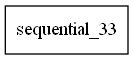

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10


KeyboardInterrupt: 

In [36]:
plot_tf = True    
# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(optimizer='adam', kernel_initializer='normal', dropout=0.2, layers_n = 64, metrics="accuracy", batchn = True, hidden_layer_sizes = [20,90], plot_tf = False, x,y):
    model = Sequential()
    model.add(Dense(layers_n,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    if batchn:
        model.add(BatchNormalization())
    model.add(Dense(1,activation='relu',kernel_initializer=kernel_initializer))
    if plot_tf:
        plot_model(model, to_file=OUTPUT_MODEL_ARCHITECTURE_RESULTS, show_shapes=True, show_layer_names=True)
        im = cv2.imread(OUTPUT_MODEL_ARCHITECTURE_RESULTS, 0)
        model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=[metrics])
        # model.summary()
        display(Image(filename=OUTPUT_MODEL_ARCHITECTURE_RESULTS))
        plot_tf = False
    else:
        model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=[metrics])
    return model

param_grid = {
    "selection__k": HYPER_PARAMETER_K_FEATURES,
    "selection__score_func": HYPER_PARAMETER_SCORE_FUNC,
    'clf__optimizer':HYPER_PARAMETER_CLASIFIER_OPTIMIZERS,
    'clf__epochs':HYPER_PARAMETER_EPOCHS,
    'clf__dropout':HYPER_PARAMETER_DROPUT,
    'clf__layers_n' : HYPER_PARAMETER_LAYERS_N,
    'clf__batchn' : HYPER_PARAMETER_BATCH_NUMBER,
    'clf__kernel_initializer':HYPER_PARAMETER_KERNEL_INITIALIZER,
    'clf__metrics':HYPER_PARAMETER_CLASIFIER_METRICS,
}

# Best alternative:
param_grid = {
    'clf__optimizer':['adam'],
    'clf__epochs':[10],
    'clf__dropout':[0.2],
    'clf__layers_n' : [64],
    'clf__kernel_initializer':['uniform'],
    'clf__metrics':['accuracy'],
    "selection__k": [30],
    "selection__score_func": [chi2],
}

create_model(optimizer=param_grid['clf__optimizer'][-1],
            dropout=param_grid['clf__dropout'][-1],
            layers_n=param_grid['clf__layers_n'][-1],
            kernel_initializer=param_grid['clf__kernel_initializer'][-1],
            metrics = param_grid['clf__metrics'][-1],
plot_tf=True)

# Using keras regresor for our custom model
clf = KerasRegressor(build_fn=create_model,verbose=3)

# Definng standart scalers
scaler = StandardScaler()

# Do feature selection with SelectKBest.
feature_selection = SelectKBest(f_classif,  k=64)  

# Oversample data with SMOTE
smote = SMOTE(sampling_strategy="minority", random_state=RANDOM_SEED)
X_train, y_train = training_features,training_targets
X_train, y_train = smote.fit_resample(training_features,training_targets)
# Min max scaler definition 
min_max_scaler =  MinMaxScaler()

# Feature selection 
feature_selection = SelectKBest()

pipeline = Pipeline([
    ('preprocess',scaler),
    ("min_max_scaler", min_max_scaler),
    ("selection", feature_selection),
    ('clf',clf)
])

# Define custom fbeta scorer function that put emphasis on recall
def custom_scorer(y_true, y_pred):
    confidence = 0
    y_pred = (np.where(y_pred > confidence, 1, 0))    
    print(confusion_matrix(y_true, y_pred))
    return fbeta_score(y_true, y_pred, beta=HYPER_PARAMETER_OPTIMIZATION_BETA)

grid = GridSearchCV(pipeline, 
                            cv=5,
                            param_grid=param_grid
                            , verbose = 3 
                            , scoring=make_scorer(custom_scorer)
                            )

grid.fit(X_train, y_train)


In [22]:
print("Best model: Acc. Score = %f, with parameters %s" % (grid.best_score_, grid.best_params_))

Best model: Acc. Score = 0.572992, with parameters {'clf__dropout': 0.2, 'clf__epochs': 10, 'clf__kernel_initializer': 'uniform', 'clf__layers_n': 64, 'clf__metrics': 'accuracy', 'clf__optimizer': 'adam', 'selection__k': 30, 'selection__score_func': <function chi2 at 0x0000017B1577CB80>}


## For single class

In [23]:
def output_parameters(confidence, grid, training_features, training_targets,evaluation_features, evaluation_targets, max_acc,best_conf, log = False ):
    from sklearn.metrics import confusion_matrix, classification_report, roc_curve, recall_score, make_scorer

    # Use all training data to calculate confusion matrix for training data
    training_estimates_ = grid.predict(training_features)
    training_estimates = np.where(training_estimates_ > confidence, 1, 0)

    training_accuracy = balanced_accuracy_score(training_targets, training_estimates)
    training_confusion_matrix = confusion_matrix(training_targets, training_estimates)

    # Use model to estimate manually labeled evaluation Tweets
    evaluation_estimates_ = grid.predict(evaluation_features)

    evaluation_estimates = np.where(evaluation_estimates_ > confidence, 1, 0)

    evaluation_accuracy = balanced_accuracy_score(evaluation_targets, evaluation_estimates)
    evaluation_confusion_matrix = confusion_matrix(evaluation_targets, evaluation_estimates)
    
    # evaluation_confusion_matrix = confusion_matrix_to_string(evaluation_confusion_matrix)
    if max_acc <= evaluation_accuracy:
        max_acc = evaluation_accuracy
        best_conf = confidence

    print(f"Confidence {confidence}")
    if log:
        print(training_estimates_)
        print("\n\n\n\n\n\n_________________________________________________")
        print(training_estimates)
        print(training_confusion_matrix)
        print(evaluation_estimates_[:5])
        print(evaluation_estimates[:5])
        print(evaluation_confusion_matrix)

    print(f"Balanced training. acc: {training_accuracy}")

    print(f"Balanced eval. acc: {evaluation_accuracy}")

    # summarize results

    if log:
        print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
        means = grid.cv_results_['mean_test_score']
        stds = grid.cv_results_['std_test_score']
        params = grid.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))

        print("Training evaluation")

        y_pred_train_ = grid.predict(training_features)
        print(y_pred_train_)
        y_pred_train = np.where(y_pred_train_ > confidence, 1, 0)
        print(classification_report(training_targets, y_pred_train))
        train_conf_matrix = confusion_matrix(training_targets, y_pred_train)

        print("Validation/evaluation")
        y_pred_test_ = grid.predict(evaluation_features) # prediction on our test set

        print(y_pred_test_)
        y_pred_test = np.where(y_pred_test_ > confidence, 1, 0)

        print(classification_report(evaluation_targets, y_pred_test))
        test_conf_matrix = confusion_matrix(evaluation_targets, y_pred_test)
        print(test_conf_matrix)
    return max_acc, best_conf

confidences =  numpy.arange(0, 1,0.02)
max_acc = 0
best_conf = 0
log = False

for confidence in confidences:
    max_acc,best_conf = output_parameters(confidence, grid, training_features, training_targets,evaluation_features, evaluation_targets, max_acc,best_conf, log = False )

print(f"max_acc {max_acc}, best_conf{best_conf}")

Confidence 0.0
Balanced training. acc: 0.6495761835848667
Balanced eval. acc: 0.640530303030303
Confidence 0.02
Balanced training. acc: 0.6580525118875336
Balanced eval. acc: 0.6446969696969697
Confidence 0.04
Balanced training. acc: 0.6674591689063469
Balanced eval. acc: 0.6526515151515151
Confidence 0.06
Balanced training. acc: 0.6789332230721521
Balanced eval. acc: 0.665530303030303
Confidence 0.08
Balanced training. acc: 0.6875501343808146
Balanced eval. acc: 0.6738636363636363
Confidence 0.1
Balanced training. acc: 0.6975770105437255
Balanced eval. acc: 0.6806818181818182
Confidence 0.12
Balanced training. acc: 0.7044366342774446
Balanced eval. acc: 0.6863636363636363
Confidence 0.14
Balanced training. acc: 0.7129501757287575
Balanced eval. acc: 0.6962121212121212
Confidence 0.16
Balanced training. acc: 0.7239073806078148
Balanced eval. acc: 0.7079545454545454
Confidence 0.18
Balanced training. acc: 0.7337647302046723
Balanced eval. acc: 0.7170454545454545
Confidence 0.2
Balanced 

In [24]:
confidence = best_conf
max_acc,best_conf = output_parameters(best_conf, grid, training_features, training_targets,evaluation_features, evaluation_targets, max_acc,best_conf, log = True )


Confidence 0.52
[0.8122701  0.45338953 0.08439553 ... 0.7451928  0.7023279  0.58131725]






_________________________________________________
[1 0 0 ... 1 1 1]
[[4143  694]
 [  25  150]]
[0.         0.5057441  0.38077897 0.06377809 0.10622675]
[0 0 0 0 0]
[[1127  193]
 [   6   38]]
Balanced training. acc: 0.8568327475708084
Balanced eval. acc: 0.8587121212121211
Best: 0.572992 using {'clf__dropout': 0.2, 'clf__epochs': 10, 'clf__kernel_initializer': 'uniform', 'clf__layers_n': 64, 'clf__metrics': 'accuracy', 'clf__optimizer': 'adam', 'selection__k': 30, 'selection__score_func': <function chi2 at 0x0000017B1577CB80>}
0.572992 (0.469592) with: {'clf__dropout': 0.2, 'clf__epochs': 10, 'clf__kernel_initializer': 'uniform', 'clf__layers_n': 64, 'clf__metrics': 'accuracy', 'clf__optimizer': 'adam', 'selection__k': 30, 'selection__score_func': <function chi2 at 0x0000017B1577CB80>}
Training evaluation
[0.8122701  0.45338953 0.08439553 ... 0.7451928  0.7023279  0.58131725]
              prec

In [25]:
current_variables = dir()

results_string = ""

for variable in current_variables:
    # Skip environment variables and their container variable
    # Ignore also underscore variables
    if variable in environment_variables or variable == "environment_variables" or variable.startswith("_"):
        continue

    # Get variables value
    variable_value = globals()[variable]

    # If variable is numerical or string, append it to results
    if type(variable_value) is str or type(variable_value) is int or \
        type(variable_value) is float or type(variable_value) is list or \
        type(variable_value) is numpy.float64 or type(variable_value) is dict:
        results_string += f"{variable}: {variable_value}\n"

# Print results to screen
print(results_string)

# Save results to file
with open(OUTPUT_RESULTS, "w") as file:
    file.write(results_string)

CROSS_VALIDATION_CV: 5
EVALUATION_FILES: ['../data/original/evaluation_dataset.csv', '..\\data\\preprocessed\\difference_preprocessed_evaluation_dataset.csv', '..\\data\\preprocessed\\ole_RemoveOutliers_and_preprocessing_pipe_evaluation_dataset.csv']
FILE_N: 2
HYPER_PARAMETER_ALPHA: [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]
HYPER_PARAMETER_BATCH_NUMBER: [20, 50, 80, 110, 140]
HYPER_PARAMETER_CLASIFIER_METRICS: ['accuracy']
HYPER_PARAMETER_CLASIFIER_OPTIMIZERS: ['rmsprop', 'adam', 'adagrad']
HYPER_PARAMETER_DROPUT: [0, 0.1, 0.2, 0.3]
HYPER_PARAMETER_EPOCHS: [10, 20, 40, 60]
HYPER_PARAMETER_HIDDEN_LAYER_SIZES: [(100,)]
HYPER_PARAMETER_KERNEL_INITIALIZER: ['glorot_uniform', 'normal', 'uniform']
HYPER_PARAMETER_K_FEATURES: [30, 40, 50, 60, 70, 80]
HYPER_PARAMETER_LAYERS_N: [20, 30, 40, 50, 60, 70, 80]
HYPER_PARAMETER_OPTIMIZATION_BETA: 2
HYPER_PARAMETER_OPTIMIZATION_CV: 5
HYPER_PARAMETER_OPTIMIZATION_SCORING: accuracy
HYPER_PARAMETER_SCORE_FUNC: [<function chi2 at 0x0000017B1577CB80>, <func

In [26]:
# !pip install import weakref

import pickle


with open(OUTPUT_MODEL, "wb") as handle:
    joblib.dump(grid, OUTPUT_MODEL)


NameError: name 'joblib' is not defined